# Implement an evolutionary algorithm
### To solve Bank Problem

The Problem

Working for a bank, you have been asked to develop an evolutionary algorithm based system which will find the largest amount of money that can be packed into a security van. The money is separated into 100 bags of different denominations and the weight and value of the money of each bag is shown on the outside of the bag, e.g., 

1. Bag 1 Weight = 9.4Kg, Value = £57
2. Bag 2 Weight = 7.4Kg, Value = £94
3. -- 
100. Bag 100 Weight = 3.9Kg, Value = £59

The security van can carry only a limited weight, so your system must try and decide which bags to put 
on the van, and which ones to leave behind. The best solution will be the one which packs the most 
money (in terms of value) into the van without overloading it. 
- Your system should read in the 100 bag values from the file “BankProblem.txt” which is provided along with this document. 
- The file contains the weight limit for the security van and the values and weights for each bag of money. Weights are all in kilos and the values are all in pounds sterling. 
- You must decide how to represent this problem to the evolutionary algorithm, you must also decide what the fitness function should be.

### The Bank Problem is given in .txt file(BankProblem.txt)
It contains the details as

security van capacity: 285

     bag 1:
         weight: 9.4
         value: 57
         
**Converting the text file to CSV**

In [722]:
import csv

filename = "BankProblem.csv"

# Open the file in write mode and create a csv.writer object
with open(filename, "w", newline="") as file:
    writer = csv.writer(file)
    
    # Open the txt file and copying data
    with open('BankProblem.txt', newline='') as f:
        reader = csv.reader(f, skipinitialspace=True, delimiter=':', quoting=csv.QUOTE_NONE)
        row_list = []
        #Removing strings and saving integers
        for row in reader:
            if row[0] == 'security van capacity' :
                continue
            else:
                bag = row[0].split()
                if len(bag) == 2:
                    row_list.append(bag[1])
                elif row[0] == 'weight':
                    row_list.append(row[1])
                elif row[0] == 'value':
                    row_list.append(row[1])
                    writer.writerow(row_list)
                    row_list = []  

### Import the required libraries

In [723]:
import pandas as pd
import numpy as np
import random
import operator
import matplotlib.pyplot as plt
from timeit import default_timer as timer

### Using the CSV file to make a dataframe using pandas

In [724]:
df = pd.read_csv('BankProblem.csv', sep = ',' , names = ['Bag','weight','amount'])

In [725]:
df.head()

,Bag,weight,amount
0,1,9.4,57
1,2,7.4,94
2,3,7.7,59
3,4,7.4,83
4,5,2.9,82


### Making lists from the dataframe

In [726]:
weights = df['weight'].values.tolist()
npweights = np.array(weights)
amounts = df['amount'].values.tolist()
npamounts = np.array(amounts)

### Global variables

In [727]:
total_weight = 285
total_bags = 100
number_of_samples = 2

### Method to Generate Random Population

In [728]:
#generating Population with 1's and 0's using population number 
def generate_population(population_size, total_bags):
    pop_list = []
    while(len(pop_list) < population_size):
        parent = np.random.randint(2, size=total_bags)
        weightSum = np.dot(parent, npweights)
        moneySum = np.dot(parent, npamounts)
        if weightSum <= total_weight:
            pop_list.append((moneySum, parent))
            
    return pop_list

### Method to Perform Binary Tournment Selection 

In [729]:
#binary tournment selection
def tournament_selection(fit_parents, t_size):
    # Selecting random parents from the population
    # t_size = tournment size which can be changed based on preference 
    random_nums = np.random.choice(fit_parents.shape[0], size=t_size, replace=False)
    
    #Taking two lists for comparision
    one = np.dot(fit_parents[random_nums[0]],npamounts)
    two = np.dot(fit_parents[random_nums[1]],npamounts)
    
    first_best = []
    second_best = []
    
    if one > two:
        first_best = fit_parents[random_nums[0]]
        second_best = fit_parents[random_nums[1]]
    else:
        first_best = fit_parents[random_nums[1]]
        second_best = fit_parents[random_nums[0]]
    
    i = 0
    #Loop to iterate among all the lists
    #Based on fitness values the first_best and second_best are updated
    while i < t_size:
        
        first = np.dot(fit_parents[random_nums[i]],npamounts)
        second = np.dot(fit_parents[random_nums[i+1]],npamounts)
        
        if first > second:
            best_in_loop = fit_parents[random_nums[i]]
        else:
            best_in_loop = fit_parents[random_nums[i+1]]
            
        if np.dot(first_best,npamounts) < np.dot(best_in_loop,npamounts):
            first_best = best_in_loop
        elif np.dot(second_best,npamounts) < np.dot(best_in_loop,npamounts):
            second_best = best_in_loop
            
        i += 2
        
    return first_best, second_best

### Method to perform Single-point Crossover 

In [730]:
def Crossover(a, b):          
    #a and b are winners of the tournment selection
    #Crossover among a and b to produce children c and d
    #Single-Point Crossover - randomNum
    
    randomNum = random.randint(1, total_bags-1)
    children = np.zeros((number_of_samples,total_bags))
    children[0] = np.concatenate((a[:randomNum],b[randomNum:]), axis=None) #c
    children[1] = np.concatenate((b[:randomNum],a[randomNum:]), axis=None) #d
    
    return children

### Method to perform Mutation

In [731]:
#mutation to c and d to produce e and f
def mutation(children, m_num):
    #M(3) – three mutation per chromosome , M(1) – one mutation per chromosome
    mutated_children = np.zeros((2,total_bags))
    for index in range(len(children)):
        mutate_child =  children[index]
        for i in range(len(mutate_child)):
            for j in range(m_num):
                k = random.uniform(0, 1)
                if k < 0.5:
                    if mutate_child[i] == 1:
                        mutate_child[i] = 0
                    else: 
                        mutate_child[i] = 1
        mutated_children[index] = mutate_child
    
    return mutated_children

### Method to Evaluate the Fitness

In [732]:
#Evaluating fitness of Mutated Children
def fitness_of_children(mutated_children, m_num):
    fit_child = []
    for num in range(len(mutated_children)):
        child = mutated_children[num]
       
        weightSum = np.dot(child, npweights)
        moneySum = np.dot(child, npamounts)
        
        if weightSum > total_weight:
            fitness_value = -1
        else:
            fit_child.append((moneySum, child))
    
    #if the children are fit and the result is not empty, then it moves towards weakest replacement
    #else if the children are not fit and empty. The mutation process runs again.
    
    if fit_child != []:
        return fit_child
    else:
        while fit_child == []:
            mutated_children = mutation(mutated_children, m_num)
            fit_child = fitness_of_children(mutated_children, m_num)
            
    return fit_child

### Method to Replace the Weakest from the list

In [733]:
#Weakest replacement of Mutated children: if the population's weakest member is weaker than the children then it is replaced.
def weakest_replacement(fit_child, best_ones):
    for n in range(0,len(fit_child)):
        if fit_child[n][0] > best_ones[-1][0]:
            best_ones[-1] = fit_child[n]
            break
            
    return best_ones

### Main method

In [734]:
def main_method(population_size, iterating_size, t_size, m_num):
    
    #Generating a random initial population
    best_ones = generate_population(population_size, total_bags)

    #First running step
    x = [] #for number of loops/iterations
    y = [] #best amount achived after every iteration

    start = timer()
    
    fit_parents = np.zeros((population_size,total_bags))
    
    #Iterating Loop
    for loop in range(iterating_size):
        x.append(loop)

        for num in range(len(best_ones)):
            fit_parents[num] = best_ones[num][1]

        
        #Main method after population is generated
        a, b = tournament_selection(fit_parents, t_size)
        
        children = Crossover(a, b)
        
        mutated_children = mutation(children, m_num)
        
        fit_child = fitness_of_children(mutated_children, m_num)
        
        best_ones = weakest_replacement(fit_child, best_ones)

        #sorting the population with respect to total Amount.
        best_ones.sort(key=operator.itemgetter(0), reverse=True)

        y.append(best_ones[0][0])

        end = timer()

    #to record the time taken for the process
    

    #Graphical Representation of the Results
    print(f'For Iterations = {iterating_size} population size = {population_size}, Tournment size = {t_size}, Mutation number = {m_num}')
    print('Time Taken : ', end - start)
    plt.plot(x, y)
    plt.xlabel('No of Loops')
    plt.ylabel('Highest Amount')
    plt.title('Iteration Comparision')
    plt.show()
    print('Max amount ',y[-1], ' time taken ', end - start) 
    print('')
    
    Final_list = [best_ones[0][0], population_size, iterating_size, t_size, m_num]
    
    return Final_list

## Main Code

**Change the values of Iteration size, tournment size, mutation number to see the changes**

For Iterations = 100000 population size = 100, Tournment size = 4, Mutation number = 1
Time Taken :  37.897053400000004


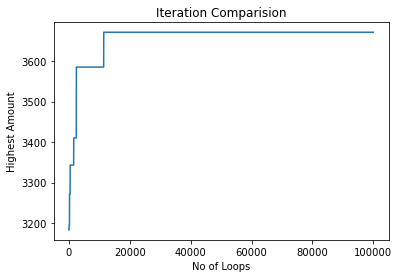

Max amount  3671.0  time taken  37.897053400000004

 Maximum Value = 3671.0  at Iterations = 100000 population size = 100, Tournment size = 4, Mutation number = 1


In [735]:
#Termination Criterion
# iterating_size = iternations number 
# t_size = tournment size 4, 8, ..
# m_num = mutation number 1,3
#population_size = 100. 150, 200

mutations = [1] #,3]
tournments = [4] #, 8]
populations = [100] #, 150, 200]
iterations = [1_00_000] #, 15_000, 20_000]

All_sols = []

for iterating_size in iterations:
    for population_size in populations:
        for t_size in tournments:
            for m_num in mutations:
                final_list = main_method(population_size, iterating_size, t_size, m_num)
                All_sols.append(final_list)

                
max_value = max(All_sols, key=lambda x: x[0])

print(f' Maximum Value = {max_value[0]}  at Iterations = {max_value[2]} population size = {max_value[1]}, Tournment size = {max_value[3]}, Mutation number = {max_value[4]}' )